# CC5215: Privacidad de Datos

## Laboratorio 8

Integrantes:

Francisco Gutiérrez Albornoz

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')

## Randomized response

## Question 1 (5 points)

Complete the definition of `encode_rand_resp_yes_no`. The true response should be returned with probability `p`, otherwise the result should be a coin flip.

In [2]:
def encode_rand_resp_yes_no(p, true_response):
    sample = np.random.random()
    if sample <= p:
        return true_response
    return np.random.randint(0, 2) == 0
    

for _ in range(5):
    print('Randomized response:', encode_rand_resp_yes_no(0.2, True))

Randomized response: False
Randomized response: True
Randomized response: True
Randomized response: True
Randomized response: False


## Question 2 (10 points)

Find the equation to calculate the privacy level, $\epsilon$, of the randomized response algorithm.

First, provide an intuition for the following questions:

- What do you think the value of `epsilon` should be if `p` is 0?
- What do you think the value of `epsilon` should be if `p` is 1?

Consideraré el ejemplo visto en la clase.
- En este caso, se responde sí o no con la misma probabilidad. Por lo tanto, sería igual de probable que se entregue la respuesta real o la falsa, de esta forma se tiene máxima privacidad ($\epsilon = 0$).
- En este otro caso, siempre se devuelve la respuesta verdadera. Por lo tanto, no hay privacidad ($\epsilon = \infty$).

Second, explain your reasoning and complete the definition of `rr_epsilon`:

En clases vimos que los casos interesantes eran 
- $P$(respuesta∣datos reales = True)
- $P$(respuesta∣datos reales = False)
​
1. Caso datos reales = True

$P(False|True) = (1 - p) \cdot 0.5 \\
P(True|True) = p + (1 - p) \cdot 0.5$

2. Caso datos reales = False

$P(False|False) = p + (1 - p) \cdot 0.5 \\
P(True|False) = (1 - p) \cdot 0.5$

Utilizando la definición 
$\displaystyle \frac{P(respuesta∣datos reales = True)}{P(respuesta∣datos reales = False)}  \leq e^{\epsilon}$

Considerando el mayor valor de los resultados anteriores se tiene que 

$$\displaystyle \frac{p + (1 - p) \cdot 0.5}{(1 - p) \cdot 0.5}  \leq e^{\epsilon}$$
$$\displaystyle \ln \left(\frac{p + (1 - p) \cdot 0.5}{(1 - p) \cdot 0.5}\right)  \leq \epsilon$$
Tomando el mayor valor posible
$$\displaystyle  \epsilon = \ln \left(\frac{1 + p}{1 - p}\right) $$

In [3]:
def rr_epsilon(p):
    return np.log((1 + p) / (1 - p))

In [4]:
# TESTS

assert np.isclose(rr_epsilon(0.3), 0.619039)
assert np.isclose(rr_epsilon(0.5), 1.098612)
assert np.isclose(rr_epsilon(0.8), 2.197224)


## Question 3 (6 points)

Write the code to plot the level of privacy for 1000 samples of probabilities between 0 and 1.

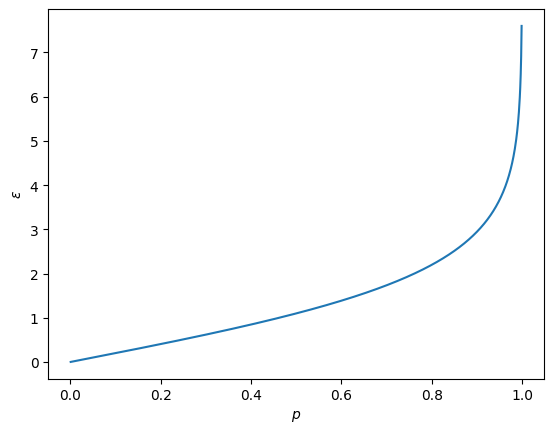

In [5]:
probs = np.linspace(0.001, 0.999, 1000)
epsilon_p = [rr_epsilon(p) for p in probs]

plt.plot(probs, epsilon_p)
plt.xlabel(r"$p$")
plt.ylabel(r"$\epsilon$")
plt.show()



- Describe the obtained plot in a few sentences. Does the plot coincides with your intuitions given in the previous question? How does increasing the probability $p$ affects the privacy level of the algorithm?

- Se tiene una curva suave que crece lento para probabilidades bajas y crece rápido para el probabilidades grandes. Para $p=0$, se tiene $\epsilon=0$. Para $p \to 1$, $\epsilon$ se hace muy grande. Con esto, a medida que la probabilidad crece, se tiene menor privacidad, por tanto coincide con la descripción previa.

## Question 4 (15 points)

Implement `decode_rand_resp_yes_no` that computes the unbiased estimator of `encode_rand_resp_yes_no`. Notice that this function is also parametrized by `p`, so the result seen in class 11 must be generalized from 0.5 to p.

_HINT_: (class 12, slide 15) -> What are the new values of `P[resp SI | ventas]` and `P[resp SI | no-ventas]`?

In [6]:
def decode_rand_resp_yes_no(p, responses):
    a = (p + 1) / 2 # P[resp sí / ventas]
    b = (1 - p) / 2 # P[resp sí / no ventas]
    return (sum(responses) - b * len(responses)) / (a - b)

# Example: 1000 "yesses" and 500 "nos"
true_responses = [True for _ in range(1000)] + [False for _ in range(500)]
print('Number of "True" yesses:', np.sum(true_responses))

# Randomized responses
# Each response satisfies 1.09-differential privacy
rand_responses = [encode_rand_resp_yes_no(0.8, r) for r in true_responses]

# Decode the responses by subtracting "fake" yesses
print('Decoded randomized response yesses:', decode_rand_resp_yes_no(0.8, rand_responses))

Number of "True" yesses: 1000
Decoded randomized response yesses: 972.5


In [7]:
BASIC_P = 0.5

# TEST CASE
true_responses = [True for _ in range(1000)] + [False for _ in range(500)]

# Randomized responses
# Each response satisfies 1.09-differential privacy
rand_responses = [encode_rand_resp_yes_no(BASIC_P, r) for r in true_responses]

# Decode the responses by subtracting "fake" yesses
assert decode_rand_resp_yes_no(BASIC_P, rand_responses) < 1100
assert decode_rand_resp_yes_no(BASIC_P, rand_responses) > 900

## Question 5 (5 points)

Implement the function `calc_rand_responses` that computes the unbiased estimator of the randomized response algorithm over a list of truthful responses. Additionally, implement `generate_rr_errors` that produces a list of length `n`, of percentual errors of RR.

In [8]:
def calc_rand_responses(p, true_responses):
    responses = [encode_rand_resp_yes_no(p, response) for response in true_responses]
    return decode_rand_resp_yes_no(p, responses)

def generate_rr_errors(n, p, true_responses):
    errors = []
    true_count = sum(true_responses)
    for _ in range(n):
        estimated_count = calc_rand_responses(p, true_responses)
        error = abs(true_count - estimated_count) / true_count * 100
        errors.append(error)
    return errors

## Question 6 (4 points)

Observe the following plot:


Average error for p=0.25: 5.724
Average error for p=0.5: 2.506
Average error for p=0.75: 1.327


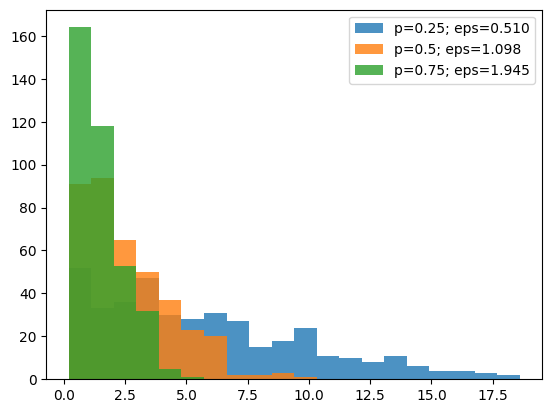

In [9]:
probabilities = [0.25, 0.5, 0.75]

bins = 20

for p in probabilities:
    errors = generate_rr_errors(400, p, true_responses)

    print("Average error for p=" + str(p) + ":", np.mean(errors))

    _, binsp, _ = plt.hist(errors, bins=bins, label='p=' + str(p) + '; eps=' + str(rr_epsilon(p))[0:5], alpha=0.8)
    
    bins = binsp

plt.legend()



- Describe the plot in a few sentences
- What properties of the randomized response algorithm can you observe?

- Se muestran gráficos de errores considerando una probabilidad en particular. A medida que aumenta la probabilidad los errores son menores (están más concentrados cerca de cero) debido a que se retorna la respuesta verdadera con mayor probabilidad.
- Se puede observar que mientras mayor es la probabilidad, menor es la privacidad (histograma con una gran cantidad de errores pequeños) ya que la respuesta se acerca más a la verdadera.

## Unary enconding

These are the definitions provided in class:

In [10]:
domain = adult['Occupation'].dropna().unique()

p, q = .75, .25

def encode(response):
    return [1 if d == response else 0 for d in domain]

def perturb(p, q, encoded_response):
    return [perturb_bit(p, q, b) for b in encoded_response]

def perturb_bit(p, q, bit):
    sample = np.random.random()
    if bit == 1:
        if sample <= p:
            return 1
        else:
            return 0
    elif bit == 0:
        if sample <= q:
            return 1
        else:
            return 0

def aggregate(p, q, responses):
    sums = np.sum(responses, axis=0)
    n = len(responses)

    return [(v - n*q) / (p-q) for v in sums]

def unary_epsilon(p, q):
    return np.log((p*(1-q)) / ((1-p)*q))

## Question 7 (5 points)

Complete the definition of `unary_sales_count`, that returns a private answer to how many people work in 'Sales', using the unary encoding algorithm.

In [11]:
def unary_sales_count(p, q):
    counts = np.sum([perturb(p, q, encode(r)) for r in adult['Occupation']], axis=0)
    L = list(zip(domain, counts))
    for pair in L:
        if pair[0] == 'Sales':
            return pair[1]

## Question 8 (6 points)

Write a script that plots the relative errors for 50 iterations of the laplace mechanism and the unary mechanism. Additionally, print the average error for both mechanisms.

_HINT_: Use `plt.subplot` to make 2 plots side-by-side.

In [12]:
errors_laplace = []
errors_unary = []
for _ in range(50):
    value = adult['Occupation'].count()
    value_laplace = laplace_mech(value, 1, 2)
    value_unary = unary_sales_count(.75, .25)
    errors_laplace.append(pct_error(value, value_laplace))
    errors_unary.append(pct_error(value, value_unary))


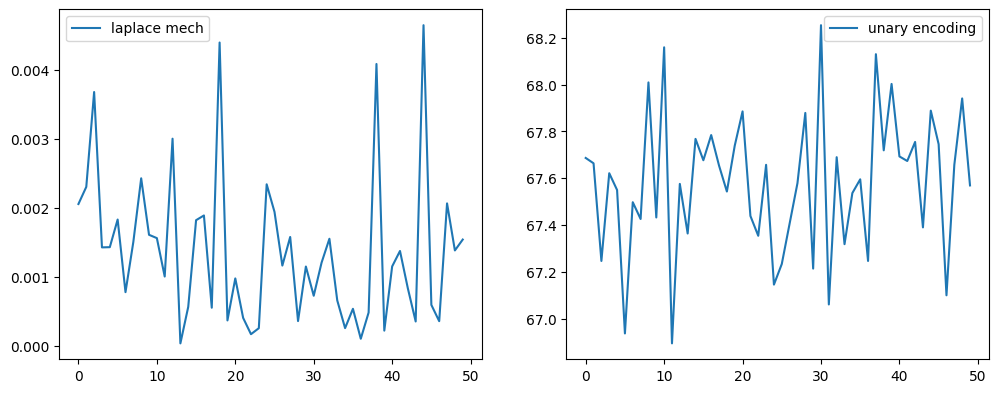

In [13]:
plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.plot(errors_laplace, label="laplace mech")
plt.legend()
plt.subplot(222)
plt.plot(errors_unary, label="unary encoding")
plt.legend()

## Question 9 (4 points)

Analyze the plot of the previous question:

- How do the accuracies of both mechanisms compare?
- Besides the difference of accuracy between the two mechanisms, what is the primary guarantee that unary encoding offers over the laplace mechanism?

- El mecanismo laplaciano ofrece una mejor precisión en comparación a unary encoding, ya que los errores mostrados en el gráfico son menores en magnitud.
- Como se tienen errores grandes para Unary encoding, este ofrece mayor privacidad. Esta mayor privacidad puede estar influido por el hecho que trabaja a nivel local.